In [26]:
                    #IMPORT MODULES
    
# Pandas Modules
import pandas as pd
import numpy as np
import datetime as dt
from pandas.plotting import table

# MatPlotLib Modules
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# SQL Alchemy (the Python SQL Toolkit and Object Relational Mapper) Modules
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [27]:
        #REFLECT DATABASE TABLES INTO THE SQL ALCHEMY ORM
    
# Create an engine to connect to the database.
eng = create_engine("sqlite:///hawaii.sqlite")

In [28]:
# The "automap_base" function automatically generates mapped classes and 
# relationships from a database schema, with the database being reflected 
# into a new model (the "Base" class).

Base = automap_base()

In [29]:
# Call Base.prepare() on the resulting Base class, asking it to reflect
# (by setting "reflect" as True) the schema and produce mappings.
# In other words, the ".prepare" function use the Base class to reflect
# the database tables.

Base.prepare(eng, reflect=True)

In [30]:
# Print all of the classes mapped to the Base by the automap function.

Base.classes.keys()

['logDF', 'metDF']

In [31]:
# Save the references to each table.

Measurements = Base.classes.metDF
Stations = Base.classes.logDF

In [32]:
# Create the session, that is the link from Pandas to the database.

session = Session(eng)

In [33]:
                    #PRECIPITATION ANALYSIS
    
# Design a query to retrieve the last 12 months of precipitation data.
# The homework assignment suggests to concentrate only on the "date" and
# "prcp" fields, load the query results into a dataframe, and set the index 
# to the date column.

# Below it's shown a clever variable that determines the data one year ago.
# We need it because the request is to capture the data for the last 12
# months.

lastYearToday = dt.date.today() - dt.timedelta(days=365)

In [34]:
# Query to get from the database the various dates and related 
# precipitation indexes.
# The character "\" placed in the code allows to break it through a new 
# line for better readibility, without altering the code.

datePrecip = session.query(Measurements.date,Measurements.prcp).\
filter(Measurements.date >= lastYearToday).all()

In [35]:
# Gather the data collected into a dataframe and print it.

DF1 = pd.DataFrame(datePrecip, columns=["Date","Precipitations"])
DF1.head()

,Date,Precipitations
0,2017-03-31,0.0
1,2017-04-01,0.0
2,2017-04-02,0.0
3,2017-04-03,0.0
4,2017-04-04,0.0


<IPython.core.display.Javascript object>


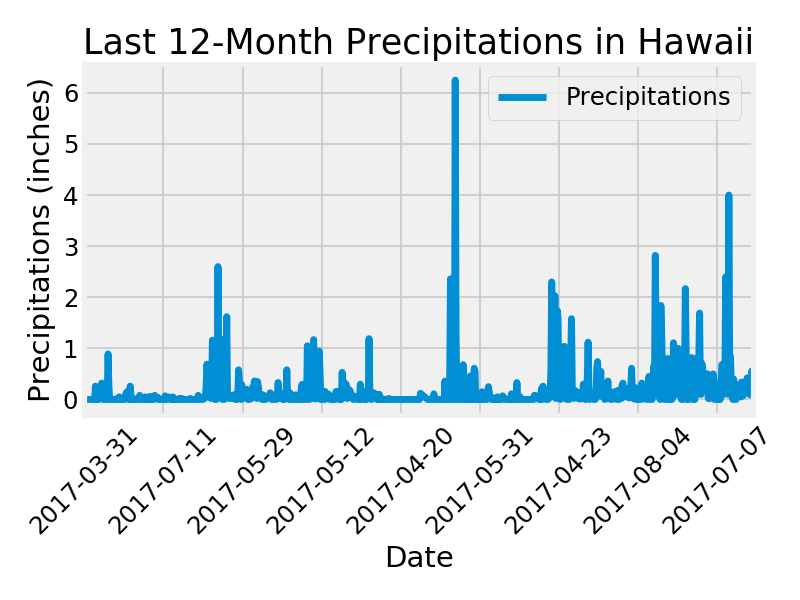

In [36]:
# Bar chart of the newly created dataframe.

DF1.plot(x="Date")

plt.title("Last 12-Month Precipitations in Hawaii")
plt.xlabel("Date")
plt.ylabel("Precipitations (inches)")

# The x-axis labels would overlap each other.  To see them, we need to 
# rotate them.

plt.xticks(rotation="45")

# Similarly, the picture would go out of the allowed area if we don't 
# apply to it the following:

plt.tight_layout()

# Show the chart

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data.
# The .describe function allows us to do this by showing us the main 
# characteristics of the data contained in the dataframe.

DF1.describe()

,Precipitations
count,847.000000
mean,0.159091
std,0.412602
min,0.000000
25%,0.000000
50%,0.020000
75%,0.126250
max,6.250000


In [37]:
                    # STATION ANALYSIS
    
# Design a query to calculate the total number of stations.
# This was actually known from the database_engineering file (lenght of
# the logDF dataframe) and was nine stations.
# Anyhow, if one had to create a query to find this out, it would be:

statCount = session.query(Stations.station).count()
statCount

9

In [38]:
# Design a query to find the most active stations.

# 1) List the stations and observations in each of them, ranked from
# highest to lowest observation count.

rankedStations = session.query(Measurements.station,Stations.name,
    func.count(Measurements.tobs)).filter(Stations.station == 
    Measurements.station).group_by(Measurements.station).\
    order_by(func.count(Measurements.tobs).desc()).all()
rankedStations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [39]:
# 2) Which station has the highest number of observations?
# The code below grabs from "rankedStations" the first row ([0]) and first
# and second column ([0:2]) (in the last expression, the right side of the
# range is excluded).
# We also keep in the expression the station ID for later.

topStation = rankedStations[0][0:2]
topStation

('USC00519281', 'WAIHEE 837.5, HI US')

In [40]:
# 3) Design a query to retrieve the last 12 months of temperature 
# observations (tobs).

# The query below determines, for the most active station ("topStation"), 
# the lowest, highest, and average temperatures, all in Farenheit degrees.

session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), 
              func.avg(Measurements.tobs)).\
    filter(Measurements.station == 'USC00519281').all()

[(54, 85, 71.66378066378067)]

<IPython.core.display.Javascript object>


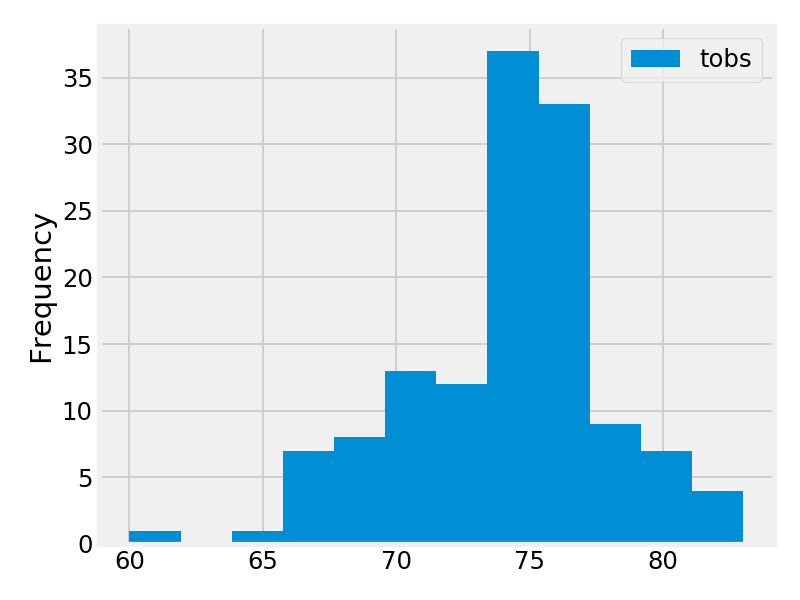

In [41]:
# Here we use again the variable "lastYearToday" to capture the last 12
# months of data.
# The y-axis below represent the number of observations in the last 12
# months for a given temperature, captured in the x-axys.

activeStation = session.query(Measurements.tobs).\
    filter(Measurements.station == 'USC00519281').\
    filter(Measurements.date >= lastYearToday).all()

DF2 = pd.DataFrame(activeStation, columns=['tobs'])
DF2.plot.hist(bins=12)
plt.tight_layout()

plt.show()

In [44]:
                        # TEMPERATURE ANALYSIS

# Write a function called "calc_temps" that will accept a start date and 
# end date in the format %Y-%m-%d and return the minimum, average, and 
# maximum temperatures for that range of dates.

def calc_temps(startDate,endDate):

    return session.query(func.min(Measurements.tobs), 
                         func.max(Measurements.tobs), 
                         func.avg(Measurements.tobs)).\
        filter(Measurements.date >= startDate).filter(Measurements.date 
                                                      <= endDate).all()

# Check that the variable "calc_temps" works by inserting sample start and
# ending dates.  The results should the minimum, maximum, and average
# temperature between these two dates.

print(calc_temps("2016-05-1","2017-01-01"))

[(60, 84, 75.75866666666667)]


In [48]:
# Use the "calc_temps" function to calculate the min, avg, and max 
# temperatures for your trip using the matching dates from the previous 
# year (i.e. use "2017-01-01" if your trip start date was "2018-01-01").

import datetime as dt

# The variables below are similar in principle to the above-defined
# "lastYearToday" variable.  So, since we are in 2018, "begPrevYear"
# results in Jan 1, 2017, and "endPrevYear" results in Dec 31, 2017.

begPrevYear = dt.date(2018,1,1) - dt.timedelta(days=365)
endPrevYear = dt.date(2018,12,31) - dt.timedelta(days=365)

minTemp,maxTemp,avgTemp = calc_temps(begPrevYear.strftime("%Y-%m-%d"), 
                              endPrevYear.strftime("%Y-%m-%d"))[0]

print(minTemp,maxTemp,avgTemp)

58 87 74.14387974230493


<IPython.core.display.Javascript object>


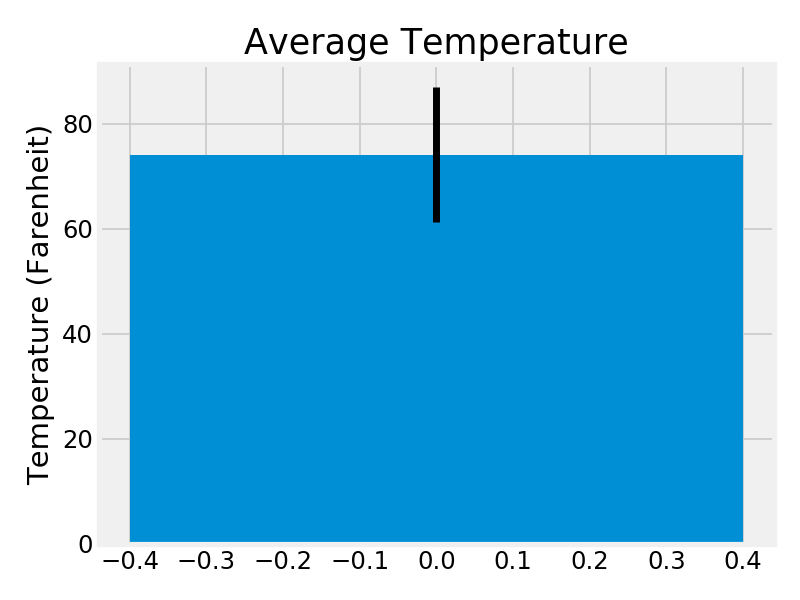

In [50]:
# Plot the min, avg, and max temperature from your previous query as a 
# bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

plt.bar(0,avgTemp,yerr=[maxTemp - avgTemp])
plt.align = 'center'
plt.figsize = (20,20)
plt.title("Average Temperature")
plt.ylabel("Temperature (Farenheit)")
plt.tight_layout()

plt.show()